<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/ResNet50_as_feature_extractor_plus_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 特徴抽出器としての ResNet50 + SVM による分類
（注意）特徴抽出にコストがかかるため，GPU 必須である。

## 必要なライブラリのインポート

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## CIFAR-10データセットの読み込み & データローダーの構築

In [3]:
def load_cifar10_data(batch_size=32):
    # データの前処理（ResNetはImageNetで学習されているため、同じ正規化を使用する）
    transform = transforms.Compose([
        transforms.Resize(224),  # ResNetの入力サイズに合わせる
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # CIFAR-10データセットを読み込み
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)

    # データローダーの構築
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    return trainloader, testloader

# データセットを読み込み
trainloader, testloader = load_cifar10_data(batch_size=64)

## 事前学習済未モデルの読み込み & パラメータ凍結

In [4]:
# 事前学習済みResNet50をロード
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# 最後の分類層（fc層）を除去して特徴抽出器を作成
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor = feature_extractor.to(device)

# パラメータを凍結
for param in feature_extractor.parameters():
    param.requires_grad = False

## 特徴抽出の処理

In [5]:
# データローダーから特徴を抽出
def extract_features(dataloader, feature_extractor, device, max_samples=None):
    features_list = []
    labels_list = []

    feature_extractor.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(dataloader)):
            if max_samples and i * dataloader.batch_size >= max_samples:
                break

            images = images.to(device)

            # 特徴抽出
            features = feature_extractor(images)
            features = features.view(features.size(0), -1)  # バッチ内の各画像を1次元に変換

            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

    # リストを結合
    all_features = np.vstack(features_list)
    all_labels = np.hstack(labels_list)

    return all_features, all_labels

# 訓練データから特徴を抽出（注意・・・計算時間短縮のため一部のデータを使用）
print("訓練データから特徴を抽出中...")
train_features, train_labels = extract_features(
    trainloader, feature_extractor, device, max_samples=10000
)

# テストデータから特徴を抽出
print("テストデータから特徴を抽出中...")
test_features, test_labels = extract_features(
    testloader, feature_extractor, device, max_samples=2000
)

print(f"訓練特徴の形状: {train_features.shape}")
print(f"テスト特徴の形状: {test_features.shape}")

訓練データから特徴を抽出中...


 20%|██        | 157/782 [00:32<02:09,  4.81it/s]


テストデータから特徴を抽出中...


 20%|██        | 32/157 [00:06<00:26,  4.75it/s]

訓練特徴の形状: (10048, 2048)
テスト特徴の形状: (2048, 2048)


## SVMを用いた分類

In [7]:
# CIFAR-10のクラス名
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# SVMを訓練
print("SVMを訓練中...")
svm_classifier = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
svm_classifier.fit(train_features, train_labels)

# テストデータで予測
print("テストデータで予測中...")
predictions = svm_classifier.predict(test_features)

# 結果を評価
accuracy = accuracy_score(test_labels, predictions)
print(f"\nテストデータに対する正解率: {accuracy:.4f}")

# 詳細な分類レポート
print("\nClassification Report:")
print(classification_report(test_labels, predictions, target_names=classes))

SVMを訓練中...
テストデータで予測中...

テストデータに対する正解率: 0.8862

Classification Report:
              precision    recall  f1-score   support

    airplane       0.90      0.91      0.91       198
  automobile       0.94      0.94      0.94       203
        bird       0.90      0.82      0.86       198
         cat       0.77      0.81      0.79       204
        deer       0.84      0.87      0.85       203
         dog       0.86      0.86      0.86       196
        frog       0.86      0.90      0.88       220
       horse       0.93      0.85      0.89       197
        ship       0.94      0.97      0.96       222
       truck       0.93      0.92      0.92       207

    accuracy                           0.89      2048
   macro avg       0.89      0.88      0.89      2048
weighted avg       0.89      0.89      0.89      2048



## (参考) 分類結果の可視化

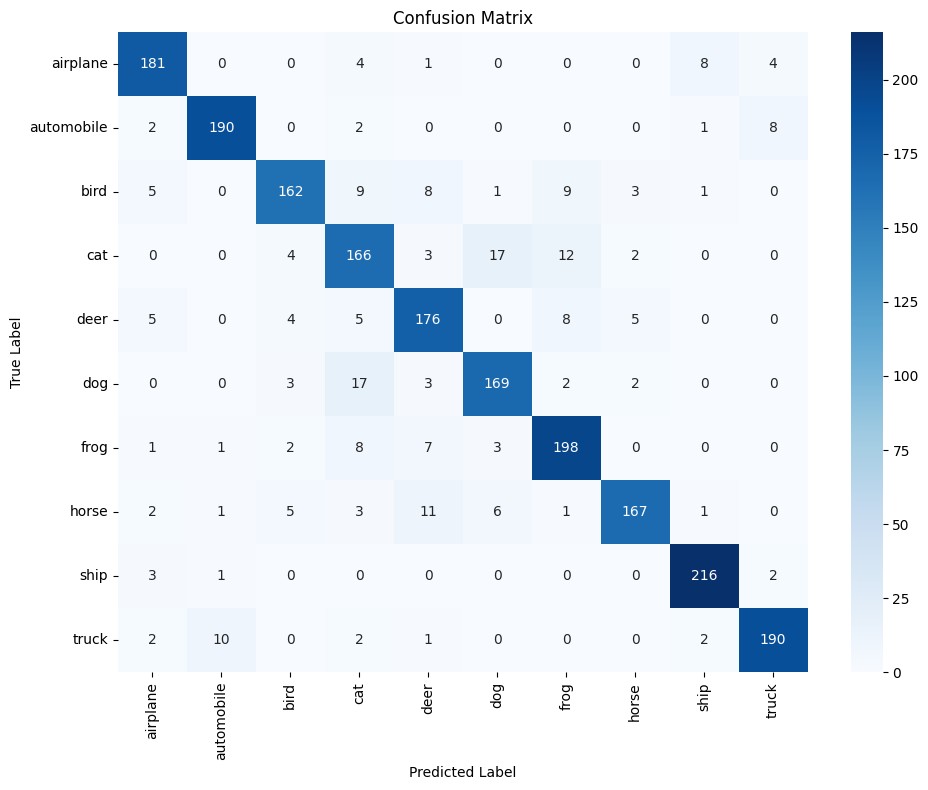

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()